In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pylops
import torch
import matplotlib.pyplot as plt
import copy
import deepinv as dinv #deepinv==0.2.2

from pylops import ricker
from pylops.utils import snr
from scipy.signal import filtfilt
from tqdm import tqdm
from PoststackLinearModelling import *
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.plotting import config_matplotlib

config_matplotlib()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
nx = 601
nz = 221
velocity_file = 'data\\Marm.bin'  # True velocity model file
v = np.fromfile(velocity_file, np.float32).reshape(nz, nx)

den = 2.0
nnx, nnz = 576, 192


# Compute x_true from raw velocity
x_true = np.log(v * 1000 * den)
x_true = x_true[:nnz, :nnx]

# Apply normalization
x_true, min_val, max_val = normalize(x_true)
x_true = torch.tensor(x_true, dtype=torch.float32, device=device)

# Deep copy to initialize x
x = copy.deepcopy(x_true)


# Time axis
nt0, dt0 = 192, 1e-7
t0 = np.arange(nt0) * dt0

# Ricker wavelet
ntwav, sigma_noise = 61, 0.01
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 15)

# -- Construct forward operator --
_A = pylops.avo.PoststackLinearModelling(
    wav / 2, nt0=nnz, spatdims=nnx, explicit=True
).A
_A = torch.from_numpy(_A).float().to(device)

physics = CustomForwardOperator(
    wav=wav, _A=_A, nt0=nnz, spatdims=nnx, explicit=False
)

# Simulate observation and add noise
y = physics(x)  
sigman = 0.1

# Generate noise using NumPy + filtfilt
# Generate and filter noise
n_np = np.random.normal(0, sigman, (nnz, nnx))
n_np = filtfilt(np.ones(10)/10, 1,
                filtfilt(np.ones(5)/5, 1, n_np.T, method='gust').T,
                method='gust')


# Make a copy to eliminate any negative strides
n_np = n_np.copy()

n = torch.from_numpy(n_np).float().to(device)

y = (y + n).float()  # Ensure y is float tensor

C:\Users\LL\AppData\Local\Temp\ipykernel_12644\2793316273.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
E:\anaconda3\envs\yolov8\lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(
d:\桌面\PnP-Diff\PoststackLinearModelling.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_np, dty

In [3]:
model = dinv.models.DiffUNet(large_model=False).to(device)

T = 1000  # Number of timesteps used during training

def get_alphas(beta_start=0.01 / 1000, beta_end=20 / 1000, num_train_timesteps=T):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas.cpu(), axis=0)  # This is \overline{\alpha}_t
    return torch.tensor(alphas_cumprod)

alphas = get_alphas().to(device)

sigmas = (torch.sqrt(1.0 - alphas) / alphas.sqrt()).to(device)

t = 80  # choose arbitrary timestep

data_fidelity = L2()

zeta = 0.3

diffusion_steps = 30  # Maximum number of iterations of the algorithm

lambda_ = 4.0  # Regularization parameter

rhos = lambda_ * (sigma_noise**2) / (sigmas**2)

# Get timestep sequence
seq = np.sqrt(np.linspace(0, T**2, diffusion_steps))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1

C:\Users\LL\AppData\Local\Temp\ipykernel_12644\1672046646.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(alphas_cumprod)


In [4]:
# the algorithm is implemented as follows:

step_20_data = {}
# Initialization
x = 2 * y - 1.0

with torch.no_grad():
    for i in tqdm(range(len(seq))):
        # Current and next noise levels
        curr_sigma = sigmas[T - 1 - seq[i]]

        # 1. Denoising step
        x0 = model(x, curr_sigma)

        if seq[i] != seq[-1]:
            # 2. Data fidelity step
            t_i = find_nearest(sigmas.cpu().numpy(), curr_sigma.cpu().numpy())

            x0 = data_fidelity.prox(x0, y, physics, gamma=1 / (2 * rhos[t_i]))

            # Normalize data for sampling
            x0 = 2 * x0 - 1
            x  = 2 * x  - 1

            # 3. Sampling step
            next_sigma = sigmas[T - 1 - seq[i + 1]].cpu().numpy()

            t_im1 = find_nearest(sigmas.cpu().numpy(), next_sigma)

            eps = (x - alphas[t_i].sqrt() * x0) / torch.sqrt(
                1.0 - alphas[t_i]
            )  # effective noise

            x = (
                alphas[t_im1].sqrt() * x0
                + torch.sqrt(1.0 - alphas[t_im1])
                  * (np.sqrt(1 - zeta) * eps + np.sqrt(zeta) * torch.randn_like(x))
            )

            # Rescale the output into [0, 1]
            x = (x + 1) / 2

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]E:\anaconda3\envs\yolov8\lib\site-packages\deepinv\models\diffunet.py:411: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(sigma).to(x.device)
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.54it/s]


In [5]:
x = denormalize(x, min_val, max_val)
x_true = denormalize(x_true, min_val, max_val)
y = y[0, 0, :, :].detach().cpu().numpy()
snr_m = snr(x_true, x)
print("Marm model SNR:", snr_m)

rmse_m = calculate_rmse(x_true, x)
print("Marm model RMSE:", rmse_m)

ssim_m, diff_image = compute_ssim(x_true, x)
print("Marm model SSIM:", ssim_m)

Marm model SNR: 40.730180740356445
Marm model RMSE: 0.07798604
Marm model SSIM: 0.8219841402616627


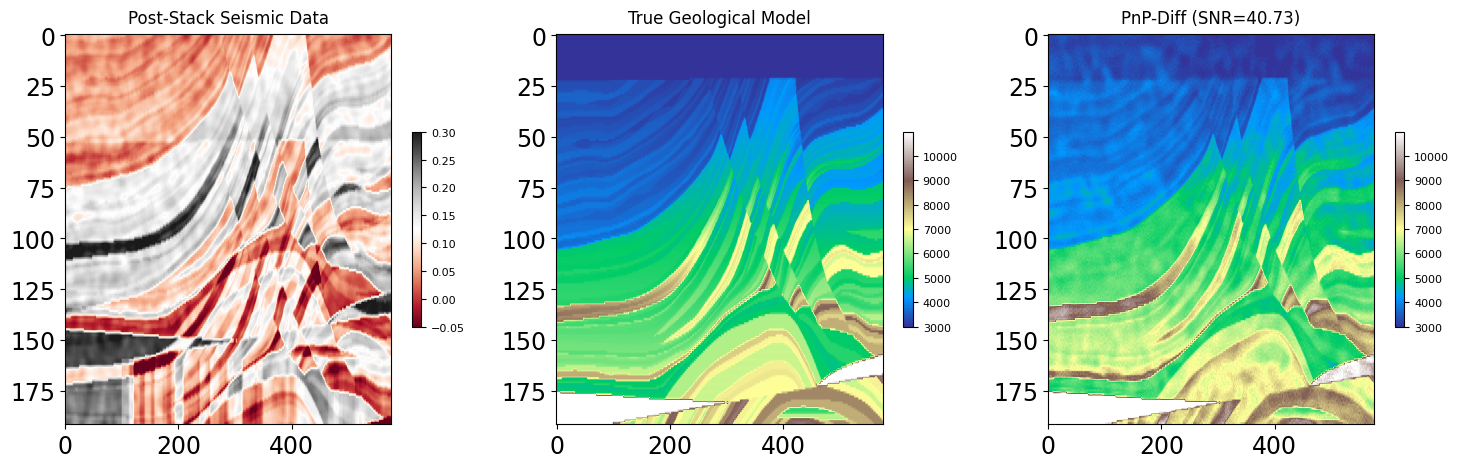

In [6]:
vmin, vmax = np.percentile(np.exp(x_true), [1, 99])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Seismic Data
ax0 = ax[0].imshow(y, cmap="RdGy", vmin=-0.05, vmax=0.3)
ax[0].set_title('Post-Stack Seismic Data', fontsize=12, pad=8)
ax[0].axis('tight')
cbar0 = fig.colorbar(ax0, ax=ax[0], shrink=0.5)
cbar0.ax.tick_params(labelsize=8)

# Subplot 2: True Model
ax1 = ax[1].imshow(np.exp(x_true), cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].set_title('True Geological Model', fontsize=12, pad=8)
ax[1].axis('tight')
cbar1 = fig.colorbar(ax1, ax=ax[1], shrink=0.5)
cbar1.ax.tick_params(labelsize=8)

# Subplot 3: Reconstructed Model
ax2 = ax[2].imshow(np.exp(x), cmap="terrain", vmin=vmin, vmax=vmax)
ax[2].set_title(r'PnP-Diff (SNR=%.2f)' % snr(x_true, x), fontsize=12, pad=8)
ax[2].axis('tight')
cbar2 = fig.colorbar(ax2, ax=ax[2], shrink=0.5)
cbar2.ax.tick_params(labelsize=8)

fig.tight_layout()
